# Score Distribution Example
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Dec 20, 2021

## Hypothesis
This notebook will explore the retention score distribution using a few different models and different teams to help understand what is the best approach for a realistic and accurate score distribution.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [165]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [166]:
# connect to SQL Server.
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ····················


In [168]:
lkupclientid = 18 # sounders2
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrUSL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.shape

(820, 55)

### We should specify the features used in our model:

In [169]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# choose the features & train year & test year
df = df[features]
df["year"] = pd.to_numeric(df["year"])

df_train = df.loc[df["year"] <= 2019]
df_train = df_train.sample(frac=0.85, random_state=786).reset_index(drop=True)

df_eval = df.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (584, 9)
Unseen Data For Predictions: (236, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [170]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's compare all models to evaluate performance. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time.

In [171]:
model_matrix = compare_models(
    fold=10,
    include=["lr", "xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6352,0.6221,0.0915,0.4783,0.1453,0.0278,0.0514,0.2600
xgboost,Extreme Gradient Boosting,0.5762,0.5486,0.3314,0.3856,0.3491,0.0426,0.0444,0.2610


In [172]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6800,0.7031,0.1111,1.0000,0.2000,0.1379,0.2722
1,0.6000,0.6111,0.0556,0.2500,0.0909,-0.0460,-0.0676
2,0.6000,0.6562,0.1111,0.3333,0.1667,-0.0163,-0.0205
3,0.5800,0.4861,0.0556,0.2000,0.0870,-0.0825,-0.1111
4,0.6400,0.6701,0.1111,0.5000,0.1818,0.0586,0.0860
5,0.6600,0.7041,0.0588,0.5000,0.1053,0.0363,0.0689
6,0.6531,0.6801,0.2353,0.5000,0.3200,0.1259,0.1420
7,0.6531,0.5404,0.1176,0.5000,0.1905,0.0672,0.0959
8,0.6122,0.5533,0.0000,0.0000,0.0000,-0.0788,-0.1504
9,0.6735,0.6158,0.0588,1.0000,0.1111,0.0755,0.1980


### Let's load in our 2021 season data and get retention scores using the model:

In [173]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(0, 9)

In [174]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.

/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/miniconda3/envs/stellar/lib/python3.7/site-packages/xgboost

In [108]:
#new_predictions = new_predictions.loc[new_predictions["productGrouping"] == "Full Season"]

array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

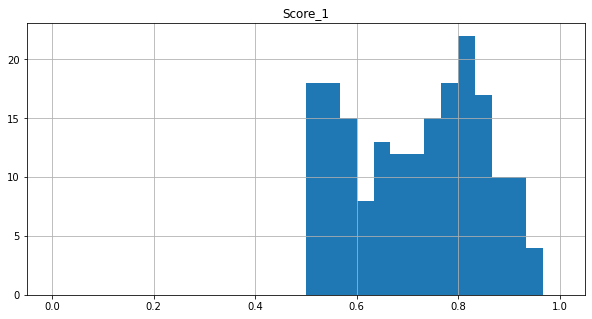

In [156]:
new_predictions[new_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,5), range=[0,1])

### Let's compare this distribution to the scores in SageMaker:

In [110]:
df_sagemaker_scores = pd.read_json('inference_data.json', lines=True)
df_sagemaker_scores.head()

,attendancePercent,isNextYear_Buyer,clientcode,dimCustomerMasterId,distToVenue,lkupclientid,missed_games_1,missed_games_2,missed_games_over_2,productGrouping,recency,recentDate,source_tenure,totalSpent,year
0,1.000000,0.1488,coyotes,785,32.26,55,0,0,0,Half Season,0,2021-12-11,1095,7446.40,2021
1,1.055556,0.2513,coyotes,3819,33.53,55,1,0,0,Half Season,0,2021-12-15,1825,2353.50,2021
2,0.962963,0.5993,coyotes,7130,8.77,55,2,0,0,Half Season,0,2021-12-15,6570,7286.25,2021
3,0.821429,0.5802,coyotes,7977,8.92,55,2,1,0,Full Season,0,2021-12-15,5840,3366.90,2021
4,0.718750,0.2595,coyotes,8362,2226.10,55,1,2,1,Full Season,0,2021-12-15,365,15432.35,2021


array([[<AxesSubplot:title={'center':'isNextYear_Buyer'}>]], dtype=object)

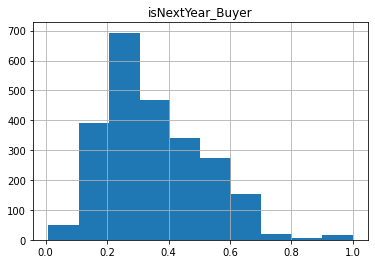

In [113]:
df_sagemaker_scores[df_sagemaker_scores["lkupclientid"]==55][["isNextYear_Buyer"]].hist()